<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import sys
sys.path.insert(0,'../fortran-package') # carico la directory con i pacchetti
from maps import nonhhenonmap
from matplotlib import animation
from IPython.display import HTML

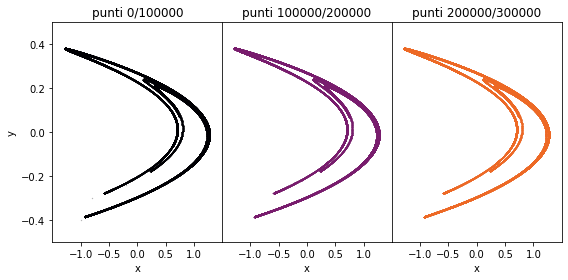

In [40]:
def main():
    """
    Funzione che riproduce il moto nella mappa di Henon.
    Come obiettivo si vuole mostrare che la mappa non collassa ad un punto, per far questo si 
    plottano separatamente diverse iterazioni (successive).
    """
    a = 1.4 # Parametri iniziali
    b = 0.3 #
    s = 100000 # Numero di Iterazioni della mappa
    x0, y0 = -1, -0.4 # Parametri iniziali del moto
    nn = 3 # numero di subplots
    
    fig, ax = plt.subplots(1, nn, figsize=(8,4))
    colors = iter(cm.inferno(np.linspace(0, 1, nn+1))) # colormap: ci bastano nn + 1 colori per questa simulazione
    
    for m in range(nn):
        x = np.ones(s)*x0 # Inizializzo array di x
        y = np.ones(s)*y0 # Inizializzo array di y
        nonhhenonmap(x, y, a, b) # richiamo la subroutine di fortran nonHhenonmap
        x0 = x[-1] # Rielaboro i valori iniziali per le iterazioni successive
        y0 = y[-1] #
        
        # Plotto i risultati nel subplot e faccio un pò di abbellimenti per gli assi
        ax[m].scatter(x, y, s = 0.1, alpha=0.4, color = next(colors))
        ax[m].set_xlabel('x')
        if m == 0: ax[m].set_ylabel('y')
        else: ax[m].get_yaxis().set_visible(False)
        ax[m].set_xlim(-1.5, 1.5)
        ax[m].set_ylim(-0.5, 0.5)
        ax[m].set_title(f'punti {m*s}/{(m+1)*s}')
        ax[m].set_xticks(np.arange(-1., 1.5, 0.5))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.)
    #plt.savefig('../../figures/22_henonmap.png', dpi = 300)
    plt.show()
main()

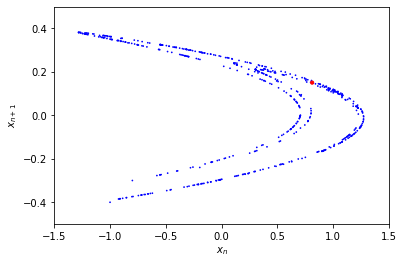

In [41]:
def henon_animation():
    """
    Animazione della mappa di Henon
    """
    my_frame = 600 # numero di frame da visualizzare
    my_ms = 150 # millisecondi tra frame

    def animate(i):
        """
        Funzione che gestisce ogni singolo step della animazione.
        In modo molto inefficiente ad ogni step si riplottano tutti i punti (dello step precedente) + 1.
        In questo modo si mostra dove va il punto successivo ed allo stesso modo si tiene traccia della storia.
        """
        ## Valori iniziali
        x0 = -1
        y0 = -.4
        a = 1.4
        b = 0.3
        x = np.ones(i+1)*x0
        y = np.ones(i+1)*y0
        ##
        # Seleziono i-1 volte il blu, l'ultimo punto lo faccio rosso per evidenziare dove va il moto.
        colors = ['blue']*(i-1) + ['red']
        nonhhenonmap(x, y, a, b) # richiamo la subroutine di fortran nonHhenonmap
        # Setto i punti sul plot con colore e grandezza diversi per evidenziare il moto.
        line1.set_offsets(np.c_[x, y])
        line1.set_color(colors)
        line1.set_sizes([0.5]*(i-1)+[10])
        return line1,
    
    # Inizializzo il grafico per l'animazione:
    fig, ax = plt.subplots()

    ax.set_xlim(( -1.5, 1.5 ))
    ax.set_ylim(( -0.5, 0.5 ))

    ax.set_xlabel(r'$x_n$')
    ax.set_ylabel(r'$x_{n+1}$')
    # Inizializzo uno scatter vuoto per inserirvi mano a mano l'animazione.
    line1, = ax.scatter([], [], ),
    # Avvio l'animazione
    anim = animation.FuncAnimation(fig, animate,
                                   frames=my_frame, interval=my_ms, blit=True)
    # Faccio in modo di poter visualizzare l'animazione qui su Jupyter
    plt.rc('animation', html='html5')
    #anim.save('../../figures/nonHhenonmap.gif', writer='imagemagick')
    return anim
henon_animation()

Quadrati occupati: 907 su 16384 (metrica divisa di un fattore 1/2^7)


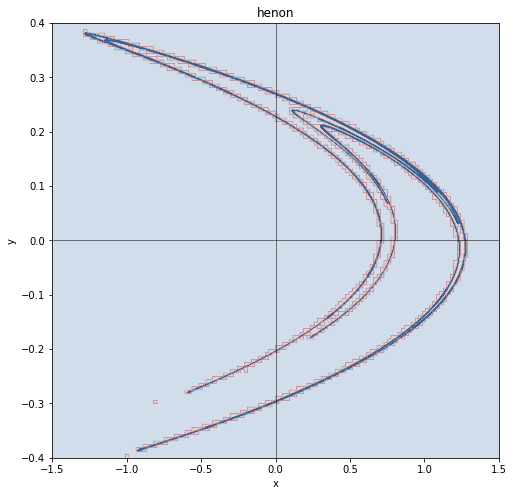

In [58]:
"""
Set di funzioni per effettuare l'algoritmo di Box Counting. 
Si è scelto un elegante (e forse inefficiente in termini di memoria) approccio ricorsivo.
"""
def go_inside(xx, yy, zz, x, y, n, nlim, N, occ):
    """
    Funzione che rientra nei 4 sottoquadranti per setacciare i punti internamente
    Ritorna la sotto matrice booleana e l'occorrenza di sotto quadrati pieni aggiornata.
    """
    # notare che ad ogni step la variabile occ viene restituita ed anche inserita (quindi aggiornata correttamente)
    zz[:N, :N], occ = box_space(xx[:N], yy[:N], zz[:N, :N], x, y, n+1, nlim, occ)
    zz[N:, :N], occ = box_space(xx[N:], yy[:N], zz[N:, :N], x, y, n+1, nlim, occ)
    zz[:N, N:], occ = box_space(xx[:N], yy[N:], zz[:N, N:], x, y, n+1, nlim, occ)
    zz[N:, N:], occ = box_space(xx[N:], yy[N:], zz[N:, N:], x, y, n+1, nlim, occ)
    return zz, occ
        
def is_inside(xx, yy, x, y):
    """
    Funzione che valuta se nel quadrato in analisi ci sono punti della mappa. 
    Per far questo fa uso di quattro maschere sull'array contenente i dati di Henon, 
    fa un "and" su tutte e quattro le maschere ed infine somma i valori dell'array booleano.
    Se nell'array c'è anche un solo "true" alora la somma sarà maggiore di 0: ->
    -> c'è un punto della mappa nel quadrato.
    """
    dx = xx[1] - xx[0] # Se non tengo di conto dell'incertezza della griglia commetto un errore
    dy = yy[1] - yy[0] #
    xm = xx[0] - dx/2  # Limite inferiore della griglia con errore (per x)
    xM = xx[-1] + dx/2 # Limite superiore della grigla con errore (per x)
    ym = yy[0] - dy/2  # ... inferiore ... (per y)
    yM = yy[-1] + dy/2 # ... superiore ... (per y)
    bool_value = ((x >= xm) & (x <= xM) & (y >= ym) & (y <= yM)).sum() != 0 # algoritmo con maschere per la ricerca
    return bool_value 

def box_space(xx, yy, zz, x, y, n, nlim, occ):
    """
    Funzione ricorsiva centrale per l'algoritmo di Box Counting.
    Questa si occupa di gestire le due funzioni precedenti e costruire la matrice zz con tante sotto matrici contenenti
    - 1: se ci sono punti della mappa nella sotto matrice
    - 0: viceversa.
    Ritorna la matrice zz aggiornata e il numero di sotto quadrati occupati relativi al livello nlim scelto.
    """
    N = len(xx) # Salvo la lunghezza di xx (siamo in blocchi quadrati: è uguale a quella di yy)
    if N == 1: # Se la lunghezza è unitaria bisogna fermarci: non si può andare più in profontità
        print('fine corsa')
        return 0, occ
    else: # Se la lunghezza è maggiore di 1
        if is_inside(xx, yy, x, y): # guardo se all'interno del quadrato c'è la mappa
            if n == nlim: # Se siamo al sotto quadrato limite
                return np.ones((N, N)), occ+1 # Inserisco una sottomatrice di 1
            else: # Se non siamo ancora al limite
                N = int(N/2) # dimezzo il range delle xx, yy (avranno una lunghezza espressa da una potenza di 2)
                zz, occ = go_inside(xx, yy, zz, x, y, n, nlim, N, occ) # Rientro nei 4 sottoquadranti e itero la ricerca
        else: # Se non c'è niente nel quadrato di questo livello
            return zz, occ # ritorno la zz opportunamente inizializzata a matrice di 0
    return zz, occ


def main_box():
    """
    Funzione che utilizza le precedenti per plottare la mappa di Henon con i box dello spazio 
    delle fasi che quest'ultima occupa.
    """
    # Parametri della mappa
    a = 1.4
    b = 0.3
    s = 100000
    # valori iniziali
    x0, y0 = -1, -0.4
    
    fig= plt.figure(figsize=(8,8))
    
    # Inizializzazione degli array e applicazione della mappa
    x = np.ones(s)*x0
    y = np.ones(s)*y0
    nonhhenonmap(x, y, a, b) # richiamo la subroutine di fortran nonHhenonmap
    
    # Creazione dei quadrati colorati dell'algoritmo di box counting
    mx = np.linspace(-1.5, 1.5, 2**10) # inizializzo due vettori con lunghezza data da potenza di due
    my = np.linspace(-0.4, 0.4, 2**10) # 
    xx, yy = np.meshgrid(mx, my, sparse=True)
    zz = np.zeros( (len(mx), len(my)) ) # inizializzo matrice nulla in questo modo no-sense ( avrà dimensioni ( len(xx.T), len(yy) ) )
    occ = 0 # Inizializzo a zero i quadrati occupati
    lim = 7 # seleziono il limite di discesa della mappa a 7 
            # (deve essere un numero inferiore alla potenza scelta per mx e my)
    zz, occ = box_space(xx.T, yy, zz, x, y, 0, lim, occ) # Applico l'algoritmo
    
    # Plottin e abbellimenti.
    plt.scatter(x, y, s = 0.01, alpha=0.4)
    plt.contourf(mx, my, zz.T, alpha=0.2, cmap="RdBu_r")
    plt.plot(0*np.ones(2**10), my, c='black', linewidth = 0.5)
    plt.plot(mx, 0*np.ones(2**10), c='black', linewidth = 0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-1.5, 1.5)
    plt.ylim(-0.4, 0.4)
    plt.title(f'henon')
    print(f'Quadrati occupati: {occ} su {2**(2*lim)} (metrica divisa di un fattore 1/2^{lim})')
    plt.show()
main_box()

[4, 10, 29, 70]


<Figure size 432x432 with 0 Axes>

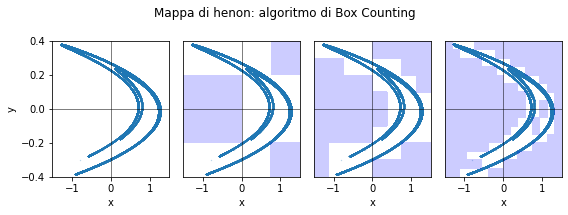

In [25]:
def main_box_belluire():
    plt.figure(figsize=(6, 6))
    a = 1.4
    b = 0.3
    s = 100000
    x0, y0 = -1, -0.4
    fig, ax = plt.subplots(1, 4, figsize=(8,3))
    x = np.ones(s)*x0
    y = np.ones(s)*y0
    nonhhenonmap(x, y, a, b) # richiamo la subroutine di fortran nonHhenonmap
    mx = np.linspace(-1.5, 1.5, 2**10)
    my = np.linspace(-0.4, 0.4, 2**10)
    occ = []
    for i in range(4):
        
        xx, yy = np.meshgrid(mx, my, sparse=True)
        zz = (xx + yy)*0
        oc0 = 0
        zz, oc0 = box_space(xx.T, yy, zz, x, y, 0, i+1, oc0)
        occ.append(oc0)

        ax[i].scatter(x, y, s = 0.1, alpha=0.4)
        ax[i].contourf(mx, my, zz.T, alpha=0.2, colors = ['blue'], levels=[0,.9])
        ax[i].plot(0*np.ones(2**10), my, c='black', linewidth = 0.5)
        ax[i].plot(mx, 0*np.ones(2**10), c='black', linewidth = 0.5)
        if i == 0:
            ax[i].set_ylabel('y')
        else:
            ax[i].get_yaxis().set_visible(False)
        ax[i].set_xlabel('x')
        ax[i].set_xlim(-1.5, 1.5)
        ax[i].set_ylim(-0.4, 0.4)
    plt.suptitle(f'Mappa di henon: algoritmo di Box Counting')
    plt.tight_layout()
    print(occ)
    #plt.savefig('../../figures/22_henonmap_box.png', dpi = 300)
    plt.show()
main_box_belluire()

Creo array
Array creati, creo la mappa
Stai valutando una matrice di 262144 punti
D = 1.276977209016705 pm 0.021220055088492052


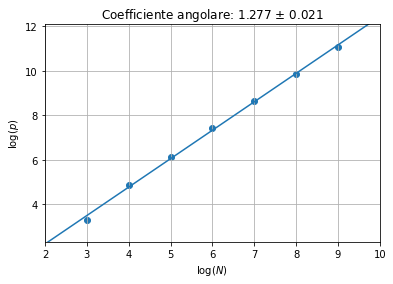

[1.000e+00 4.000e+00 1.000e+01 2.900e+01 7.100e+01 1.710e+02 3.980e+02
 9.190e+02 2.176e+03]


In [6]:
def go_inside_upgraded(xx, yy, x, y, n, nlim, N, occ):
    """
    Funzione che rientra nei 4 sottoquadranti per setacciare i punti internamente
    Ritorna la sotto matrice booleana e l'occorrenza di sotto quadrati pieni aggiornata.
    """
    occ = box_space_upgraded(xx[:N], yy[:N], x, y, n+1, nlim, occ)
    occ = box_space_upgraded(xx[N-1:], yy[:N], x, y, n+1, nlim, occ)
    occ = box_space_upgraded(xx[:N], yy[N-1:], x, y, n+1, nlim, occ)
    occ = box_space_upgraded(xx[N-1:], yy[N-1:], x, y, n+1, nlim, occ)
    return occ

def is_inside_upgraded(xx, yy, x, y):
    """
    Funzione che valuta se nel quadrato in analisi ci sono punti della mappa. 
    Per far questo fa uso di quattro maschere sull'array contenente i dati di Henon, 
    fa un "and" su tutte e quattro le maschere ed infine somma i valori dell'array booleano.
    Se nell'array c'è anche un solo "true" alora la somma sarà maggiore di 0: ->
    -> c'è un punto della mappa nel quadrato.
    """
    xm = xx[0] #- dx/2  # Limite inferiore della griglia con errore (per x)
    xM = xx[-1] #+ dx/2 # Limite superiore della grigla con errore (per x)
    ym = yy[0] #- dy/2  # ... inferiore ... (per y)
    yM = yy[-1] #+ dy/2 # ... superiore ... (per y)
    bool_array = (x >= xm) & (x <= xM) & (y >= ym) & (y <= yM) # Array di true dove i punti della mappa 
                                                               # stanno nell'intervallo
    # Genialata: ogni volta che entro qui porto fuori solo i punti della mappa
    #            che stanno nell'intervallo: abbatte drasticamente il tempo di computazione.
    aux = np.where(bool_array == True) 
    x = x[aux]
    y = y[aux]
    bool_value = x.size != 0 # algoritmo con maschere per la ricerca
    return bool_value, x, y

def box_space_upgraded(xx, yy, x, y, n, nlim, occ):
    """
    Si può migliorare l'algoritmo di box counting per il solo conteggio di quadrati occupati.
    La struttura è la stessa di box_space, adesso la matrice la inizializziamo nella funzione in modo tale da 
    non perdere risoluzione nella discesa (e non saturare la memoria per creare matrici enormi).
    In conclusione la matrice non è più restituita, si restiuisce solo i quadrati occupati per livello.
    """
    N = len(xx) # Salvo la lunghezza di xx (siamo in blocchi quadrati: è uguale a quella di yy)
    if N == 1: # Se la lunghezza è unitaria bisogna fermarci: non si può andare più in profontità
        print('fine corsa')
        return occ
    else: # Se la lunghezza è maggiore di 1
        bool_value, x, y = is_inside_upgraded(xx, yy, x, y)
        if bool_value: # guardo se all'interno del quadrato c'è la mappa
            occ[n] = occ[n]+1
            if n == nlim: # Se siamo al sotto quadrato limite
                return occ # Inserisco una sottomatrice di 1
            else: # Se non siamo ancora al limite
                dx = xx[1] - xx[0] # serve per fare la griglia giusta
                dy = yy[1] - yy[0] # //
                mx = np.linspace(xx[0], xx[-1], 3) # Ricalcolo gli mx
                my = np.linspace(yy[0], yy[-1], 3) # Ricalcolo gli my
                xx, yy = np.meshgrid(mx, my, sparse=True ) # Faccio la griglia
                N = 2
                occ = go_inside_upgraded(xx.T, yy, x, y, n, nlim, N, occ) # Rientro nei 4 sottoquadranti e itero la ricerca
    return occ


def evaluate_D():
    """
    Questa volta uso una tecnica più raffinata:
    - prendo una griglia quadrata i cui vertici sono i confini dello spazio delle fasi che voglio studiare
    - Valuto se nella griglia 3x3 ci sono punti della mappa
    - se ci sono allora divido in quattro parti la griglia
    - ogni sotto parte diventa una griglia 3x3 se ci sono punti della mappa 
        (PLUS: se non ci sono non occorre creare ulteriori griglie!!)
    - Conto ad ogni livello quanti quadrati sono occupati.
    Bouns: perchè 3x3? perché non un numero pari a dividere? 
            Risposta: perchè è 3 è il numero più piccolo che prende estremi e centro dell'intervallo. Selezionare un
                      numero pari avrebbe fatto escludere pezzi dello spazio delle fasi al povero algoritmo.
    """
    # Soliti parametri iniziali
    a = 1.4
    b = 0.3
    s = 1000000
    x0, y0 = -1, -0.4
    print('Creo array')
    x = np.empty(s)
    x[0] = x0
    y = np.empty(s)
    y[0] = y0
    print('Array creati, creo la mappa')
    
    # Limite di profontità (lineare) che esploro.
    nlim = 9
    nonhhenonmap(x, y, a, b) # richiamo la subroutine di fortran nonHhenonmap
    print(f'Stai valutando una matrice di {2**nlim*2**nlim} punti')
    # Creo nuovamente la griglia, questa volta però la faccio solo 3x3
    mx = np.linspace(-1.5, 1.5, 3)
    my = np.linspace(-0.4, 0.4, 3)
    occ = np.zeros(nlim)
    eps = np.array([2**i for i in range(1, nlim+1)])
    xx, yy = np.meshgrid(mx, my, sparse=True) # Griglia 3x3
    
    occ = box_space_upgraded(xx.T, yy, x, y, 0, nlim-1, occ)
    
    
    # Fit dei minimi quadrati
    y = np.log2(occ[2:])
    x = np.log2(eps[2:])
    D = y/x
    def f(x, m, q):
        return m * x + q
    init = [1., 0.]
    popt, pcov = curve_fit(f, x, y, p0=init)
    x_array = np.linspace(2, nlim+1, 100)
    plt.plot(x_array, f(x_array, *popt))
    print(f'D = {popt[0]} pm {np.sqrt(np.diag(pcov))[0]}')
    
    # Plot dei risultati
    plt.scatter(x, y)
    plt.xlim(2,nlim+1)
    plt.ylim(np.min(y)-1,np.max(y)+1)
    plt.grid()
    plt.xlabel(r'$\log(N)$')
    plt.ylabel(r'$\log(p)$')
    plt.title(fr'Coefficiente angolare: {popt[0]:.3f} $\pm$ {np.sqrt(np.diag(pcov))[0]:.3f}')
    # plt.savefig('../../figures/22_box_fit.png', dpi=300)
    plt.show()
    print(occ)
evaluate_D()

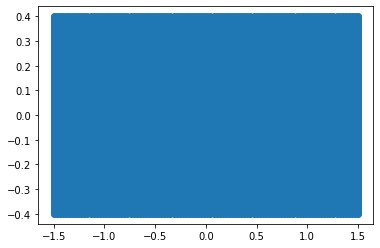

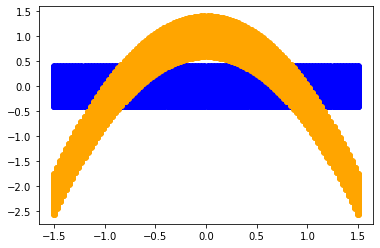

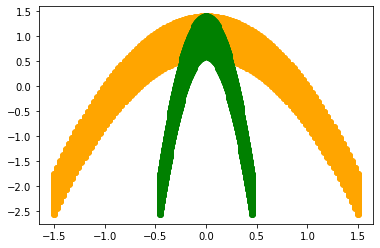

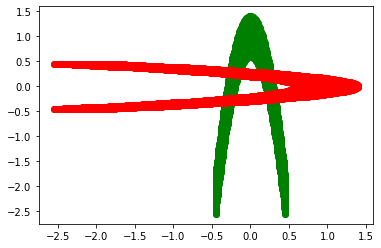

In [112]:
def m1(x, y, a):
    x = x
    y = y + 1 - a * x**2
    return x, y
def m2(x, y, b):
    x = b * x
    y = y
    return x, y
def m3(x, y):
    xaux = x
    x = y
    y = xaux
    return x, y

def henon_3_step():
    mx = np.linspace(-1.5, 1.5, 100)
    my = np.linspace(-0.4, 0.4, 100)
    xx, yy = np.meshgrid(mx, my, sparse=True)
    # Soliti parametri iniziali
    a = 1.4
    b = 0.3
    s = 3
    xii, yii = [], []
    xi, yi = [], []
    x1, y1 = [], []
    x2, y2 = [], []

    for x0 in xx.T:
        for y0 in yy:
            xii.append(x0) 
            yii.append(y0)
            x = np.ones(s)*x0
            y = np.ones(s)*y0
            x[0], y[0] = m1(x[0], y[0], a)
            xi.append(x[0]) 
            yi.append(y[0])
            x[1], y[1] = m2(x[0], y[0], b)
            x1.append(x[1]) 
            y1.append(y[1])
            x[2], y[2] = m3(x[1], y[1])
            x2.append(x[2]) 
            y2.append(y[2])
            
            
    ll = int(len(xx.T)*len(yy)*s/3)
    
    xii = np.reshape(np.array(xii), ll) # Faccio un reshape per avere array 1D
    yii = np.reshape(np.array(yii), ll) # Faccio reshape per array 1D
    
    xi = np.reshape(np.array(xi), ll) # Faccio un reshape per avere array 1D
    yi = np.reshape(np.array(yi), ll) # Faccio reshape per array 1D
    
    x1 = np.reshape(np.array(x1), ll) # Faccio un reshape per avere array 1D
    y1 = np.reshape(np.array(y1), ll) # Faccio reshape per array 1D
    
    x2 = np.reshape(np.array(x2), ll) # Faccio un reshape per avere array 1D
    y2 = np.reshape(np.array(y2), ll) # Faccio reshape per array 1D
    plt.scatter(xii, yii,)
    plt.show()
    plt.scatter(xii, yii, c='blue')
    plt.scatter(xi, yi, c='orange')
    #plt.savefig('../../figures/22_step1henon.png', dpi = 200)
    plt.show()
    plt.scatter(xi, yi,c='orange')
    plt.scatter(x1, y1,c='green')
    #plt.savefig('../../figures/22_step2henon.png', dpi = 200)
    plt.show()
    plt.scatter(x1, y1,c='green')
    plt.scatter(x2, y2,c='red')
    #plt.savefig('../../figures/22_step3henon.png', dpi = 200)
    plt.show()
henon_3_step()